## LLM Performance Following Many Rules

This notebook explores the ability of various LLM models to handle an increasing number of rules or constraints to follow within the prompt. Through personal experience, I’ve observed that LLMs often forget instructions or fail to recall previous context. This experiment attempts to quantify the limit of rules an LLM can effectively manage.

The experiment involves asking the LLM to generate text that adheres to a specific list of constraints found in `rule_options.csv`. Each rule is simple on its own (e.g., 'Mention a museum'). However, when asked to follow 20 rules, the LLM's performance begins to decline (see results below).

Interestingly, the model with the largest context window, Gemini 1.5, does not perform the best. Notably, Google's promotion of this model emphasizes its performance in needle-in-a-haystack tests rather than its ability to reason about the entire context (refer to this [Google blog post](https://blog.google/technology/ai/google-gemini-next-generation-model-february-2024/)).

This experiment also connects to ongoing work with [LLM routers](https://github.com/pulzeai-oss/knn-router). If a prompt is particularly complex, it could be routed to a more advanced model or an 'agent' that uses a divide & conquer strategy, or does a QA step and more iteration before delivering the result.

In [22]:
import pandas as pd
import random
import os
from dotenv import load_dotenv
from openai import OpenAI
import anthropic
import google.generativeai as genai

In [23]:

load_dotenv()

openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
genai_api_key = os.getenv('GEMINI_API_KEY')

openai_client = OpenAI(api_key=openai_api_key)
anthropic_client = anthropic.Client(api_key=anthropic_api_key)
genai.configure(api_key=genai_api_key)

In [24]:
models = [
    {"name": "gpt-3.5-turbo", "provider": "OpenAI"},
    {"name": "gpt-4o", "provider": "OpenAI"},
    { "name": "gemini-1.5-pro", "provider": "Google"},
    {"name": "claude-3-5-sonnet-20240620", "provider": "Anthropic"}
]

In [25]:
min_samples = 1
max_samples = 35
num_seeds = 10
results_dir = 'results'

options = pd.read_csv('rule_options.csv', header=None)

# Create the results directory if it doesn't exist
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

In [26]:
def sample_options(options: pd.DataFrame, num_rules: int, seed: int) -> pd.DataFrame:
    """
    Randomly sample a specified number of rules from a DataFrame of options.

    :param options: DataFrame containing rule options
    :param num_rules: Number of rules to sample
    :param seed: Seed for randomization
    :return: DataFrame with sampled rules
    """
    # Ensure the seed is set for deterministic randomization
    if seed is not None:
        random.seed(seed)
    
    # Randomly sample the specified number of rules
    return options.sample(n=num_rules, random_state=seed)

In [27]:
initial_prompt_template = """
Write me a text of any length that follows to the following constraints. Ensure that each constraint is clearly and obviously implemented:

<constraints>
{CONSTRAINTS}
</constraints>
"""

evaluation_prompt_template = """
Your job is to analyze a text and assess how well it follows a constraint

<text>
{TEXT}
</text>

<constraint>
It mentions a(n) {CONSTRAINT}.
</constraint>

Please carefully read through the text and assess how well it follows to the rule. If it does follow the rule, please respond with the text snippet where the constraint is followed within <snippet></snippet> tags. If it does not meet there rule you should leave this section empty. 
Then, please fill in the <result> tags with either TRUE or FALSE
"""

In [28]:
def build_prompt(constraints: list[str]) -> str:
    """
    Build an initial prompt with a list of constraints.

    :param rules: List of constraints
    :return: Formatted prompt string
    """
    formatted_constraints = '\n'.join(f"{i+1}. It mentions a(n) {constraint}." for i, constraint in enumerate(constraints))
    return initial_prompt_template.replace('{CONSTRAINTS}', formatted_constraints)

def get_completion(prompt: str, model: str, provider: str) -> str:
    if provider == "OpenAI":
        response = openai_client.chat.completions.create(
            model=model,
            messages=[
                {"role": "user", "content": prompt}
            ],
        )
        return response.choices[0].message.content
    elif provider == "Anthropic":
        message = anthropic_client.messages.create(
            model=model,
            max_tokens=4096,
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": prompt
                        }
                    ]
                }
            ]
        )
    
        return message.content[0].text
    elif provider == "Google":
        g_model = genai.GenerativeModel(model)
        response = g_model.generate_content(prompt)
        print('response text', response.text)
        return response.text
    else:
        raise ValueError(f"Unsupported provider: {provider}")
    

In [29]:
def evaluate_completion(completion: str, constraint: str) -> str:
    """
    Evaluate how well a completion follows to a specific constraint.

    :param completion: The completion text to evaluate
    :param constraint: The constraint to evaluate against
    :return: Evaluation result
    """
    prompt = evaluation_prompt_template.replace('{CONSTRAINT}', constraint).replace('{TEXT}', completion)
    evaluation = get_completion(prompt, "gpt-4o", 'OpenAI')
    return evaluation   

def evaluate_all_rules(completion: str, constraints: list[str]):
    evaluation_results = []
    for constraint in constraints:
        result = evaluate_completion(completion, constraint)
        evaluation_results.append({
            "rule": constraint,
            "result": result
        })
    return evaluation_results

In [30]:
def calculate_success_rate(evaluation_results: list[dict]) -> float:
    """
    Calculate the percentage of constraints that are followed based on evaluation results.

    :param evaluation_results: List of dictionaries containing evaluation results for each constraint
    :return: Percentage of constraints that are followed
    """
    total_constraints = len(evaluation_results)
    if total_constraints == 0:
        return 0.0
    
    rules_met = sum(1 for result in evaluation_results if '<result>TRUE</result>' in result["result"].replace('\n', ''))    
    percentage_met = (rules_met / total_constraints) * 100
    return percentage_met

In [31]:
def get_results():
    for model in models:
        model_results_file = os.path.join(results_dir, f"{model['name']}_results.csv")

        if not os.path.exists(model_results_file):
            df_results = pd.DataFrame(columns=["model", "provider", "seed", "sample_size", "prompt", "completion", "rule", "result"])
        else:
            df_results = pd.read_csv(model_results_file)

        for sample_size in range(min_samples, max_samples + 1):
            for seed in range(num_seeds):
                sampled_options = sample_options(options, sample_size, seed)
                prompt = build_prompt(sampled_options[0].values)

                # Check if the prompt has already been evaluated
                if not df_results[(df_results['prompt'] == prompt) & (df_results['model'] == model["name"]) & (df_results['seed'] == seed) & (df_results['sample_size'] == sample_size)].empty:
                    continue

                completion = get_completion(prompt, model["name"], model['provider'])
                results = evaluate_all_rules(completion, sampled_options[0].values)

                for result in results:
                    new_row = pd.DataFrame({
                        "model": [model["name"]],
                        "provider": [model["provider"]],
                        "seed": [seed],
                        "sample_size": [sample_size],
                        "prompt": [prompt],
                        "completion": [completion],
                        "rule": [result["rule"]],
                        "result": [result["result"]]
                    })
                    df_results = pd.concat([df_results, new_row], ignore_index=True)

                # Save results to the model-specific CSV after each seed
                df_results.to_csv(model_results_file, index=False)

In [32]:
get_results()

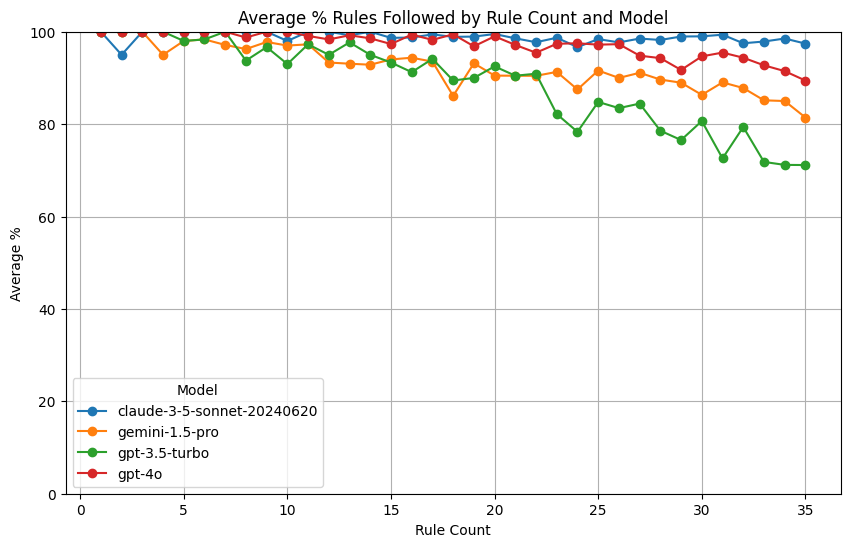

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Directory where the results are stored
results_dir = 'results'

# Load all CSV files in the results directory
dfs = []
for file_name in os.listdir(results_dir):
    if file_name.endswith('_results.csv'):
        df = pd.read_csv(os.path.join(results_dir, file_name))
        dfs.append(df)

# Combine all DataFrames into one
df_results = pd.concat(dfs, ignore_index=True)
# Calculate the percentage met for each sample size, seed, and model
df_results['percentage_met'] = df_results.apply(
    lambda row: '<result>TRUE</result>' in row['result'].replace('\n', ''),
    axis=1
).astype(int)

# Group by sample size, seed, and model, then calculate the mean percentage met for each group
df_grouped = df_results.groupby(['sample_size', 'seed', 'model'])['percentage_met'].mean().reset_index()

# Group by sample size and model to get the average percentage met for each sample size and model
df_avg_percentage_met = df_grouped.groupby(['sample_size', 'model'])['percentage_met'].mean().reset_index()

# Convert the percentage met to a percentage
df_avg_percentage_met['percentage_met'] *= 100

# Plot the results
plt.figure(figsize=(10, 6))

# Plot each model separately
for model in df_avg_percentage_met['model'].unique():
    df_model = df_avg_percentage_met[df_avg_percentage_met['model'] == model]
    plt.plot(df_model['sample_size'], df_model['percentage_met'], marker='o', label=model)

plt.ylim(0, 100)
plt.xlabel('Rule Count')
plt.ylabel('Average %')
plt.title('Average % Rules Followed by Rule Count and Model')
plt.legend(title='Model')
plt.grid(True)
plt.show()